In [1]:
import os
from datetime import datetime
from PIL import Image
from shutil import copyfile

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
from torch import optim

from model import Net

import utils

sns.set()

In [2]:
print(torch.__version__)

1.2.0


In [3]:
data_dir = "dataset/"
train_dir = data_dir + "train/"
valid_dir = data_dir + "valid/"

now = datetime.now()
dt_string = now.strftime("%d%m%Y-%H%M%S")
model_target_folder = "models/model-" + dt_string + "/"

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# Load the dataset

In [5]:
transform_train = transforms.Compose([
    #transforms.Resize((64,64)),
    #transforms.CenterCrop(64),
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
transform_validation_test = transforms.Compose([
    #transforms.Resize((64,64)),
    #transforms.CenterCrop(64),
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define transforms used for the training and validation sets
data_transforms = [transform_train, transform_validation_test]

# Load the datases with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=data_transforms[0])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms[1])

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=batch_size, num_workers=num_workers)

# Classes in the dataset

In [6]:
import json

# Get classes names
classes = {}
for index, name in enumerate(train_data.classes):
    classes[index] = name
    
# Save to JSON
with open('labels_to_class_names.json', 'w', encoding='utf-8') as file:
    json.dump(classes, file, ensure_ascii=False, indent=4)

# Show classes
classes

{0: 'bicycle',
 1: 'bus',
 2: 'car',
 3: 'motorcycle',
 4: 'pickuptruck',
 5: 'truck',
 6: 'van'}

# Visualization of the classes

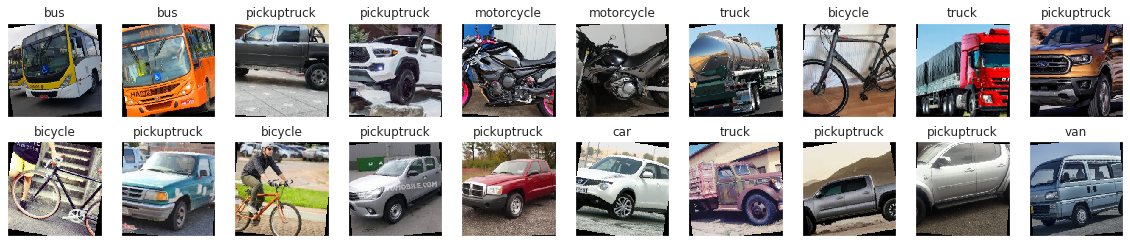

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images, labels = images.numpy(), labels.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    utils.imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Building Classifier

In [8]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)
        
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

#model = Net()
#model.apply(init_weights)
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
#for param in model.parameters():
#    param.requires_grad = False

In [10]:
# define the Classifier architecture
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
         # linear layer (1024 -> 512)
        self.fc1 = nn.Linear(2048, 1024)
        # linear layer (512 -> 256)
        self.fc2 = nn.Linear(1024, 256)
        # linear layer (256 -> 102)
        self.fc3 = nn.Linear(256, 7)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
classifier = Classifier()
classifier

Classifier(
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=7, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

# Model Params

In [11]:
# Change the pre-trained model classifier
model.fc = classifier

n_epochs = 1000
learning_rate = 0.01
max_epochs_without_improvement = 9

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate) # 0.01

scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=4, factor=0.1)

# Training the classifier

In [12]:
%%time

utils.create_directory(model_target_folder)
copyfile("model.py", model_target_folder + "model.py")

train_on_gpu = torch.cuda.is_available()
model.class_to_idx = train_data.class_to_idx

#train_on_gpu = False
valid_loss_min = np.Inf # track change in validation loss
if(train_on_gpu):
    model.cuda()
else:
    model.cpu()
    
epochs_without_improvement = 0
valid_losses = []
valid_accs = []
valid_precs = []
valid_recalls = []

train_losses = []
train_accs = []
train_precs = []
train_recalls = []
for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    y_true_train = []
    y_true_valid = []
    y_pred_train = []
    y_pred_valid = []
    train_loss = 0.0
    valid_loss = 0.0
    
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Save the predictions
        y_true_train.append(target.data.cpu())
        y_pred_train.append(pred.data.cpu())
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # Save the predictions
        y_true_valid.append(target.data.cpu())
        y_pred_valid.append(pred.data.cpu())
        
    scheduler.step(valid_loss)
    
    y_true_train = np.array(torch.cat(y_true_train))
    y_pred_train = np.array(torch.cat(y_pred_train))
    y_true_valid = np.array(torch.cat(y_true_valid))
    y_pred_valid = np.array(torch.cat(y_pred_valid))
    
    # Calculate the metrics
    train_acc = metrics.accuracy_score(y_true_train, y_pred_train) * 100.0
    train_prec = metrics.precision_score(y_true_train, y_pred_train, average='macro') * 100.0
    train_recall = metrics.recall_score(y_true_train, y_pred_train, average='macro') * 100.0
    
    valid_acc = metrics.accuracy_score(y_true_valid, y_pred_valid) * 100.0
    valid_prec = metrics.precision_score(y_true_valid, y_pred_valid, average='macro') * 100.0
    valid_recall = metrics.recall_score(y_true_valid, y_pred_valid, average='macro') * 100.0
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    train_precs.append(train_prec)
    valid_precs.append(valid_prec)
    train_recalls.append(train_recall)
    valid_recalls.append(valid_recall)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch {} Training Loss: {:.6f}      \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print('         Training Accuracy: {:.2f}%\tValidation Accuracy: {:.2f}%'.format(
        train_acc, valid_acc))
    print('         Training Precision: {:.2f}%\tValidation Precision: {:.2f}%'.format(
        train_prec, valid_prec))
    print('         Training Recall: {:.2f}%\t\tValidation Recall: {:.2f}%'.format(
        train_recall, valid_recall))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:         
        epochs_without_improvement = 0
        print('         Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        state = {'epoch': epoch,
                 'learning_rate': learning_rate,
                 'batch_size': batch_size,
                 'state_dict': model.state_dict(),
                 'optimizer': optimizer.state_dict(), 
                 'valid_loss': valid_loss,
                 'valid_acc': valid_acc,
                 'valid_prec': valid_prec,
                 'valid_recall': valid_recall,
                 'train_loss': train_loss,
                 'train_acc': train_acc,
                 'train_prec': train_prec,
                 'train_recall': train_recall,
                 'criterion': criterion, 
                 'class_to_idx': model.class_to_idx,
                 'transform': transform_validation_test,
                 'labels_map': classes}
        torch.save(state, model_target_folder + 'model.pt')

        valid_loss_min = valid_loss
    else:
        epochs_without_improvement += 1
    # Early Stopping
    if epochs_without_improvement > max_epochs_without_improvement:
        print("\nTraining finished due to %s epochs without improvement\n" % max_epochs_without_improvement)
        break
    print("")

/home/rodrigoamf/anaconda3/envs/vehicle-classification/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1 Training Loss: 1.918798      	Validation Loss: 1.871327
         Training Accuracy: 24.28%	Validation Accuracy: 26.67%
         Training Precision: 14.25%	Validation Precision: 3.81%
         Training Recall: 15.23%		Validation Recall: 14.29%
         Validation loss decreased (inf --> 1.871327).  Saving model ...

Epoch 2 Training Loss: 1.850744      	Validation Loss: 1.793034
         Training Accuracy: 26.97%	Validation Accuracy: 27.18%
         Training Precision: 25.22%	Validation Precision: 18.11%
         Training Recall: 15.07%		Validation Recall: 14.84%
         Validation loss decreased (1.871327 --> 1.793034).  Saving model ...

Epoch 3 Training Loss: 1.768258      	Validation Loss: 1.684348
         Training Accuracy: 28.71%	Validation Accuracy: 36.92%
         Training Precision: 30.38%	Validation Precision: 32.82%
         Training Recall: 16.83%		Validation Recall: 24.65%
         Validation loss decreased (1.793034 --> 1.684348).  Saving model ...

Epoch 4 Train


Epoch 27 Training Loss: 0.066115      	Validation Loss: 0.189204
         Training Accuracy: 99.23%	Validation Accuracy: 93.85%
         Training Precision: 99.09%	Validation Precision: 94.38%
         Training Recall: 99.17%		Validation Recall: 92.26%

Epoch 28 Training Loss: 0.081690      	Validation Loss: 0.181195
         Training Accuracy: 98.65%	Validation Accuracy: 94.36%
         Training Precision: 98.98%	Validation Precision: 95.27%
         Training Recall: 98.18%		Validation Recall: 93.40%
         Validation loss decreased (0.183623 --> 0.181195).  Saving model ...

Epoch 29 Training Loss: 0.058162      	Validation Loss: 0.176866
         Training Accuracy: 98.84%	Validation Accuracy: 94.87%
         Training Precision: 98.90%	Validation Precision: 95.73%
         Training Recall: 98.69%		Validation Recall: 94.24%
         Validation loss decreased (0.181195 --> 0.176866).  Saving model ...

Epoch 30 Training Loss: 0.058234      	Validation Loss: 0.186880
         Trainin

# Plot model performance during the training

In [13]:
epochs = list(range(1, len(valid_losses)+1))
best_model_epoch = epoch - max_epochs_without_improvement - 1
markers_on = [best_model_epoch]

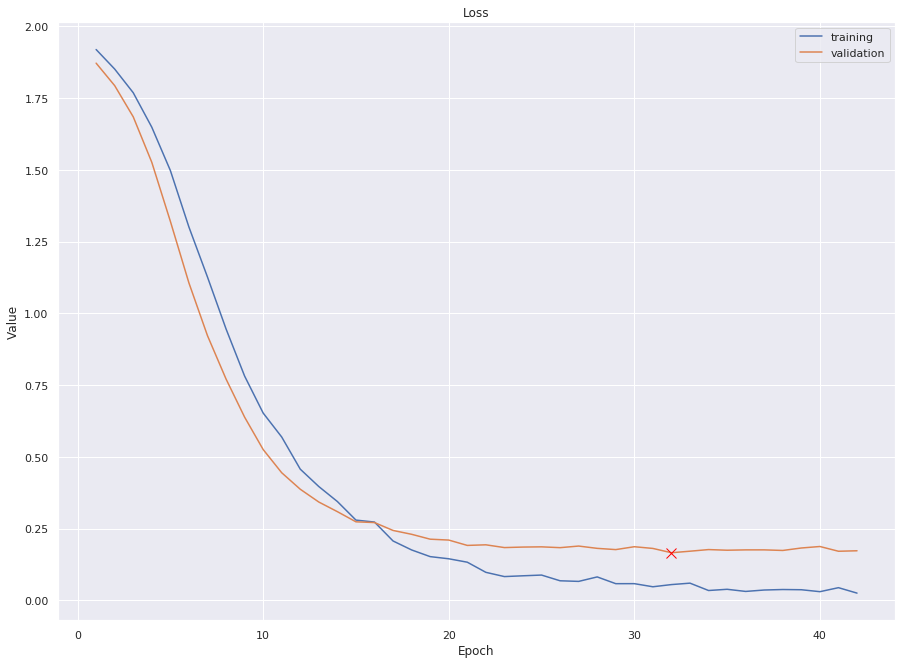

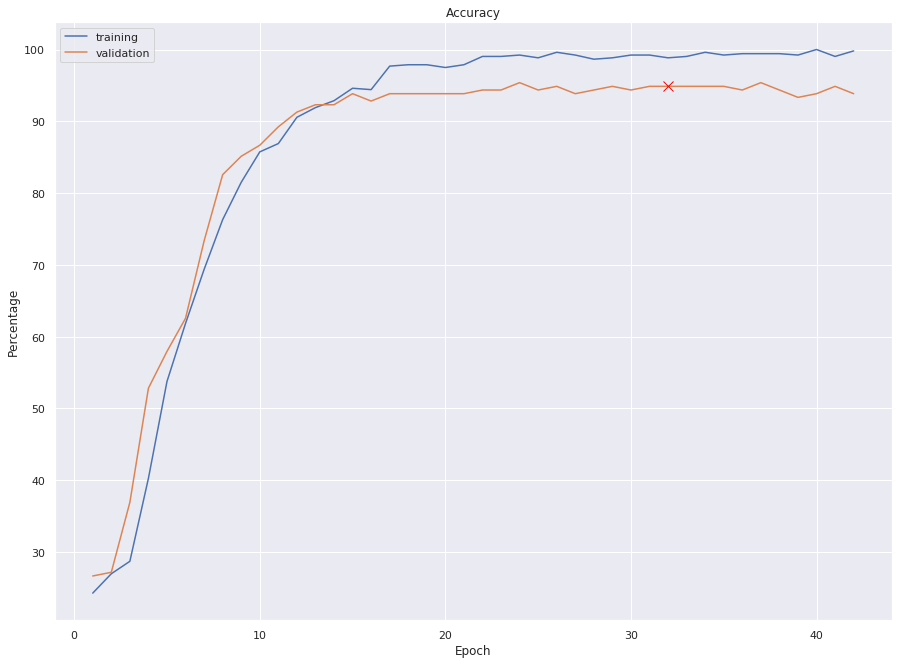

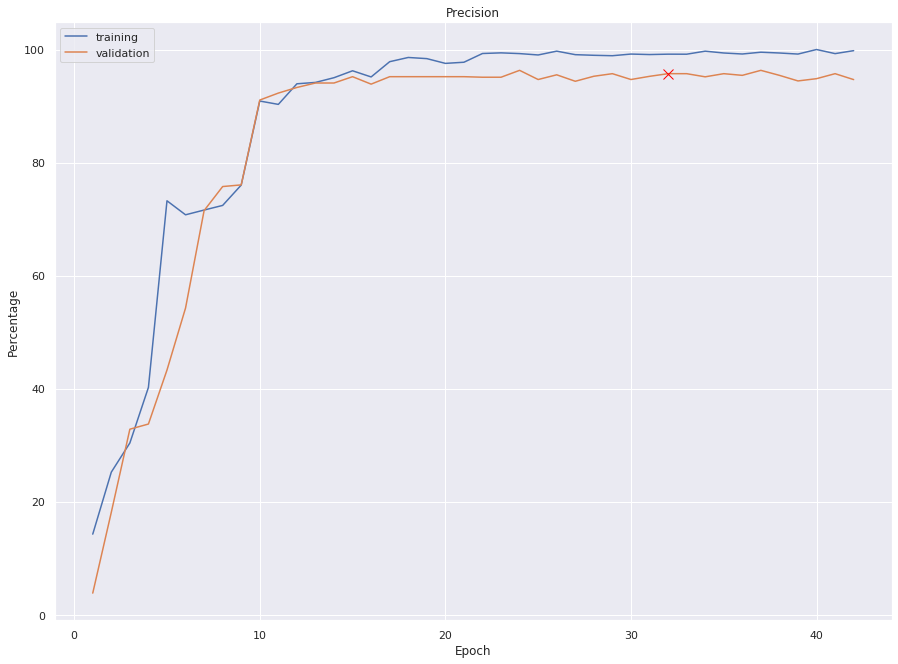

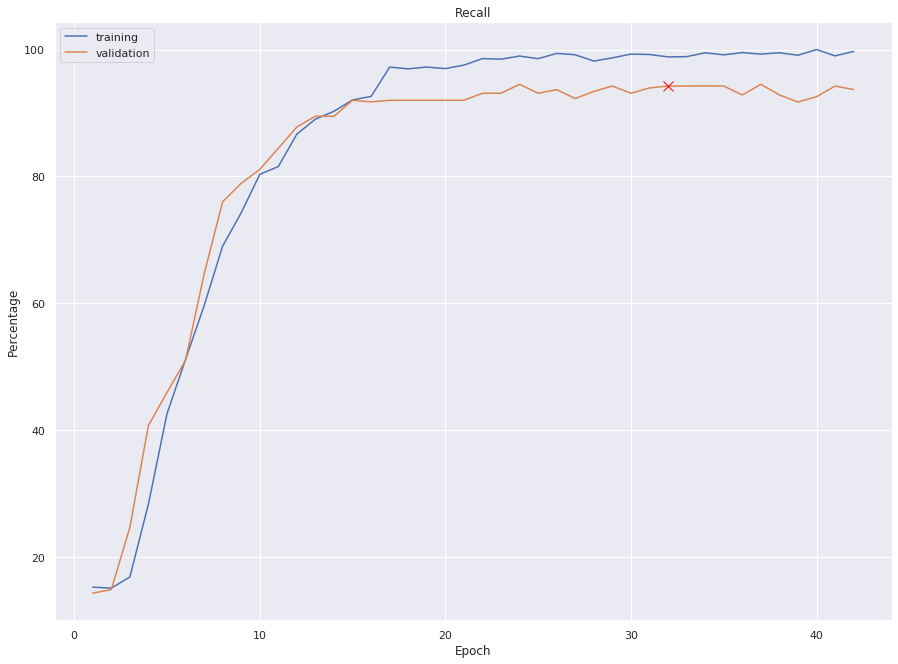

In [14]:
fig = plt.figure(figsize = (15,11))

plt.plot(epochs, train_losses, label='training')
plt.plot(epochs, valid_losses, label='validation')
plt.plot(best_model_epoch, valid_losses[best_model_epoch - 1], marker='x', markersize=10, color="red")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title("Loss")
plt.legend()
fig.savefig(model_target_folder + 'loss.png', dpi=fig.dpi)

plt.show()

fig = plt.figure(figsize = (15,11))
plt.plot(epochs, train_accs, label='training')
plt.plot(epochs, valid_accs, label='validation')
plt.plot(best_model_epoch, valid_accs[best_model_epoch - 1], marker='x', markersize=10, color="red")
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.title("Accuracy")
plt.legend()
fig.savefig(model_target_folder + 'accuracy.png', dpi=fig.dpi)

fig = plt.figure(figsize = (15,11))
plt.plot(epochs, train_precs, label='training')
plt.plot(epochs, valid_precs, label='validation')
plt.plot(best_model_epoch, valid_precs[best_model_epoch - 1], marker='x', markersize=10, color="red")
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.title("Precision")
plt.legend()
fig.savefig(model_target_folder + 'precision.png', dpi=fig.dpi)

fig = plt.figure(figsize = (15,11))
plt.plot(epochs, train_recalls, label='training')
plt.plot(epochs, valid_recalls, label='validation')
plt.plot(best_model_epoch, valid_recalls[best_model_epoch - 1], marker='x', markersize=10, color="red")
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.title("Recall")
plt.legend()
fig.savefig(model_target_folder + 'recall.png', dpi=fig.dpi)

plt.show()